In [1]:
!pip install --upgrade hepml
!pip install arrow
!pip install keras_lr_finder
# reload modules before executing user code
#%load_ext autoreload
# reload all modules every time before executing Python code
#%autoreload 2
# render plots in notebook
%matplotlib inline
import datetime
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from hepml.core import plot_regression_tree
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!unzip drive/MyDrive/"jLab Shared Docs"/"MFC Modeling"/stanfordMFCDataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.4/526.4 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.6 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=1c3934848172d1294b1dd3e04c58d5e9242dd5fe503752154690fadb0bd699f2
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d9758207

In [2]:
#Load teros data
import glob
teros_files = glob.glob("rocket4/TEROSoutput*.csv")
X = pd.DataFrame()
for f in teros_files:
  try:
    csv = pd.read_csv(f, index_col=False).dropna()
    X = pd.concat([X, csv])
  except:
    continue

In [3]:
#Load power data
power_files = glob.glob("rocket4/soil*.csv")
y = pd.DataFrame()
for f in sorted(power_files, key=lambda x: int(x.split('.')[0].split('_')[-1])):
#in power_files:
  try:
    csv = pd.read_csv(f, on_bad_lines='skip', skiprows=10).dropna(how='all')
    csv = csv.rename({'Unnamed: 0': 'timestamp'}, axis='columns')
    y = pd.concat([y,csv])
  except:
    continue
y["timestamp"] = y["timestamp"].round(decimals = 1)

In [4]:
#Convert current to amps, voltage to volts
y["I1L [10pA]"] = np.abs(y["I1L [10pA]"] * 10E-12)
y["V1 [10nV]"] = np.abs(y["V1 [10nV]"] * 10E-9)
y["I1H [nA]"] = np.abs(y["I1H [nA]"] * 10E-9)

In [105]:
#Sort data by timestamp, convert to datetime
X = X.sort_values(['timestamp'])
y = y.sort_values(['timestamp'])
X['timestamp'] = pd.to_datetime(X['timestamp'], unit='s')
y['timestamp'] = pd.to_datetime(y['timestamp'], unit='s')

#Merge data by timestamp
uncut_df = pd.merge_asof(left=X,right=y,direction='nearest',tolerance=pd.Timedelta('1 sec'), on = 'timestamp').dropna(how='all')

#Isolate data from cell0
df = uncut_df.loc[uncut_df['sensorID'] == 0]

#Localize timestamp
df.timestamp = df.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')

#Get time since deployement
df['tsd'] = (df['timestamp'] - df['timestamp'][840344]).dt.days

<ipython-input-105-82a78218b4d4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.timestamp = df.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
<ipython-input-105-82a78218b4d4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tsd'] = (df['timestamp'] - df['timestamp'][840344]).dt.days


In [106]:
#Use only data from after deployment date
#df = df.loc[(df['timestamp'] > '2021-09-24') & (df['timestamp'] < '2021-10-15')] #Future of Clean Computing Graph
#df = df.loc[(df['timestamp'] > '2021-06-24') & (df['timestamp'] < '2021-07-02')]
df = df.loc[(df['timestamp'] > '2021-06-18')] #Two weeks after deployment
#df = df.loc[(df['timestamp'] > '2021-06-25') & (df['timestamp'] < '2021-06-26')] #Small training set

#Power drop
#df = df.loc[(df['timestamp'] > '2021-11-01') & (df['timestamp'] < '2021-11-22')]

#Calculate power
df["power"] = np.abs(np.multiply(df.iloc[:, 8], df.iloc[:, 9]))
#df["power"] = np.abs(np.multiply(df["I1L [10pA]"], df["V1 [10nV]"]))

df['power'] = df['power']*1E9

In [107]:
df["I1L [10pA]"] = np.abs(df["I1L [10pA]"] * 10E6)
df["V1 [10nV]"] = np.abs(df["V1 [10nV]"] * 10E3)
df["I1H [nA]"] = np.abs(df["I1H [nA]"] * 10E3)

In [108]:
df = df.resample('3min', on='timestamp').mean().iloc[1: , :]

In [109]:
df = df.rolling('1h', on = df.index).mean().iloc[20: , :]

In [110]:
#Add power time series
df['power - 1h'] = df['power'].shift(1).dropna()
#df['power - 2h'] = df['power'].shift(2).dropna()
#df['previous_power - 3'] = df['power'].shift(3).dropna()
#df['previous_power - 4'] = df['power'].shift(4).dropna()

#Add teros time series
df['EC - 1h'] = df['EC'].shift(1).dropna()
df['temp - 1h'] = df['temp'].shift(1).dropna()
df['raw_VWC - 1h'] = df['raw_VWC'].shift(1).dropna()

#Add voltage and current time series
df['V1 - 1h'] = df['V1 [10nV]'].shift(1).dropna()
df['I1L - 1h'] = df['I1L [10pA]'].shift(1).dropna()
df['I1H - 1h'] = df['I1H [nA]'].shift(1).dropna()
df = df.dropna()

In [111]:
df

,sensorID,raw_VWC,temp,EC,I1L_valid,I2L_valid,I1H [nA],I1L [10pA],V1 [10nV],V2 [10nV],...,I2L [10pA],tsd,power,power - 1h,EC - 1h,temp - 1h,raw_VWC - 1h,V1 - 1h,I1L - 1h,I1H - 1h
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-06-21 11:21:00-07:00,0.0,2480.597151,32.006099,227.678022,1.0,1.0,2.501779,155.235721,870.455771,-6.856148e+06,...,3.396390e+06,0.0,1460.990116,1517.788735,227.496154,32.043407,2480.229357,862.015316,161.411035,2.462468
2021-06-21 11:24:00-07:00,0.0,2480.950305,31.970330,227.943407,1.0,1.0,2.434922,156.501534,891.439275,-6.864503e+06,...,3.467492e+06,0.0,1498.666837,1460.990116,227.678022,32.006099,2480.597151,870.455771,155.235721,2.501779
2021-06-21 11:27:00-07:00,0.0,2481.170945,31.936484,228.064011,1.0,1.0,2.418291,159.241593,914.472575,-6.876390e+06,...,3.486939e+06,0.0,1536.049381,1498.666837,227.943407,31.970330,2480.950305,891.439275,156.501534,2.434922
2021-06-21 11:30:00-07:00,0.0,2481.401060,31.906484,228.290934,1.0,1.0,2.404508,158.137323,920.308137,-6.809262e+06,...,3.468806e+06,0.0,1526.084066,1536.049381,228.064011,31.936484,2481.170945,914.472575,159.241593,2.418291
2021-06-21 11:33:00-07:00,0.0,2481.611522,31.878791,228.548626,1.0,1.0,2.317007,158.708093,949.658357,-6.829612e+06,...,3.549590e+06,0.0,1569.222111,1526.084066,228.290934,31.906484,2481.401060,920.308137,158.137323,2.404508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-27 23:54:00-08:00,0.0,2695.936170,10.632500,218.366209,1.0,1.0,5.885739,228.065564,144.524713,-4.301010e+06,...,7.052299e+05,220.0,326.740084,318.596719,218.227747,10.642500,2695.886286,145.750024,221.960063,5.854377
2022-01-27 23:57:00-08:00,0.0,2696.069440,10.622500,218.493132,1.0,1.0,5.991499,234.798666,137.211368,-4.306208e+06,...,5.981103e+05,220.0,318.101537,326.740084,218.366209,10.632500,2695.936170,144.524713,228.065564,5.885739
2022-01-28 00:00:00-08:00,0.0,2696.181901,10.612500,218.573901,1.0,1.0,6.012082,243.118706,129.960976,-4.309820e+06,...,5.862817e+05,220.0,308.276448,318.101537,218.493132,10.622500,2696.069440,137.211368,234.798666,5.991499


In [112]:
#Re-split data for training
#X = pd.concat([df.iloc[:, 1:2], df.iloc[:, 15:16], df.iloc[:, 17:19], df.iloc[:, 11:15]], axis = 1)#.dropna()
#y = df.iloc[:, 10:11]#.dropna()

#Creating training and testing sets (without rolling)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 2:5], df.iloc[:, 13:14], df.iloc[:, 15:19]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(df.iloc[:, 14:15], test_size=0.3, shuffle=False)

#Creating training and testing sets (with roll)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 1:2], df.iloc[:, 17:18], df.iloc[:, 19:20], df.iloc[:, 3:4], df.iloc[:, 9:10], df.iloc[:, 13:17]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(pd.concat([df.iloc[:, 12:13]], axis = 1), test_size=0.3, shuffle=False)

#Creating training and testing sets (with roll)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 17:21], df.iloc[:, 1:2], df.iloc[:, 21:22], df.iloc[:, 23:24], df.iloc[:, 2:3], df.iloc[:, 4:5], df.iloc[:, 10:11], df.iloc[:, 25:26], df.iloc[:, 15:16], df.iloc[:, 13:15], df.iloc[:, 24:25]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(pd.concat([df.iloc[:, 16:17]], axis = 1), test_size=0.3, shuffle=False)

#Creating training and testing sets (with roll, hour)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 15:19], df.iloc[:, 1:2], df.iloc[:, 19:20], df.iloc[:, 21:22], df.iloc[:, 2:3], df.iloc[:, 4:5], df.iloc[:, 10:11], df.iloc[:, 13:14], df.iloc[:, 22:23]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(pd.concat([df.iloc[:, 14:15]], axis = 1), test_size=0.3, shuffle=False)

#Creating training and testing sets (with roll, no hour)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 15:19], df.iloc[:, 2:3], df.iloc[:, 20:21], df.iloc[:, 23:24]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(pd.concat([df.iloc[:, 14:15]], axis = 1), test_size=0.3, shuffle=Fa`lse)

X_train, X_test = train_test_split(pd.concat([df["power - 1h"], df["V1 - 1h"], df["I1L - 1h"], df["EC - 1h"], df["raw_VWC - 1h"], df["temp - 1h"], df["tsd"]], axis = 1), test_size=0.3, shuffle=False)
y_train, y_test = train_test_split(pd.concat([df["power"], df['V1 [10nV]'], df['I1L [10pA]']], axis = 1), test_size=0.3, shuffle=False)

In [113]:
#reshape data
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [114]:
from keras.models import load_model
model = load_model("drive/MyDrive/jLab Shared Docs/MFC Modeling/lstm_3min")
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

719/719 [==============================] - 1s 2ms/step


In [115]:
#Evaluate SMAPE
#print("Train SMAPE:\n", SMAPE(y_train.values.ravel(), train_pred))
#print("Test SMAPE:\n", SMAPE(y_test.values.ravel(), test_pred))

#Evaluate MAPE
print("Train MAPE power:\n", MAPE(y_train['power'].values.ravel(), train_pred[:, 0]))
print("Test MAPE power:\n", MAPE(y_test['power'].values.ravel(), test_pred[:, 0]))

#Evalaute MAE
print("Train MAE power:\n", mean_absolute_error(y_train['power'].values.ravel(), train_pred[:, 0]))
print("Test MAE power:\n", mean_absolute_error(y_test['power'].values.ravel(), test_pred[:, 0]))

Train MAPE power:
 0.10681006708386097
Test MAPE power:
 0.030922198747024243
Train MAE power:
 12.6103210935397
Test MAE power:
 9.570796935328866


In [116]:
#Evaluate MAPE
print("Train MAPE voltage:\n", MAPE(y_train['V1 [10nV]'].values.ravel(), train_pred[:, 1]))
print("Test MAPE voltage:\n", MAPE(y_test['V1 [10nV]'].values.ravel(), test_pred[:, 1]))

#Evalaute MAE
print("Train MAE voltage:\n", mean_absolute_error(y_train['V1 [10nV]'].values.ravel(), train_pred[:, 1]))
print("Test MAE voltage:\n", mean_absolute_error(y_test['V1 [10nV]'].values.ravel(), test_pred[:, 1]))

Train MAPE voltage:
 0.12272937519665668
Test MAPE voltage:
 0.046397684295413084
Train MAE voltage:
 13.747518068748674
Test MAE voltage:
 5.869688516941579


In [118]:
#Evaluate MAPE
print("Train MAPE current:\n", MAPE(y_train['I1L [10pA]'].values.ravel(), train_pred[:, 2]))
print("Test MAPE current:\n", MAPE(y_test['I1L [10pA]'].values.ravel(), test_pred[:, 2]))

#Evalaute MAE
print("Train MAE current:\n", mean_absolute_error(y_train['I1L [10pA]'].values.ravel(), train_pred[:, 2]))
print("Test MAE current:\n", mean_absolute_error(y_test['I1L [10pA]'].values.ravel(), test_pred[:, 2]))

Train MAPE current:
 0.0724907743429421
Test MAPE current:
 0.031582953216750725
Train MAE current:
 15.012015905062059
Test MAE current:
 7.4576231802308


In [119]:
predictions = model.predict(np.concatenate((X_train, X_test)))

2397/2397 [==============================] - 7s 3ms/step


In [120]:
mv1 = df
mv1["power_pred"] = predictions[:, 0]
#mv1 = mv1.loc[(df['timestamp'] > '2021-11-24')]
mv1["error"] = np.abs(mv1["power"] - mv1["power_pred"])

In [121]:
mv1["voltage_pred"] = predictions[:, 1]
mv1["current_pred"] = predictions[:, 2]
mv1 = mv1.loc[(mv1.index > '2021-12-12') & (mv1.index < '2021-12-14')]
#mv1 = mv1.iloc[1915:2298]
mv2 = mv1

In [ ]:
mv1.loc[(mv1.index > '2021-11-11') & (mv1.index < '2021-11-22')]

,sensorID,raw_VWC,temp,EC,I1L_valid,I2L_valid,I1H [nA],I1L [10pA],V1 [10nV],V2 [10nV],...,EC - 1h,temp - 1h,raw_VWC - 1h,V1 - 1h,I1L - 1h,I1H - 1h,power_pred,error,voltage_pred,current_pred
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-11-11 01:00:00-08:00,0.0,2604.634585,15.805069,257.649770,1.0,1.0,4.082512,220.784129,123.616985,-3.192077e+06,...,256.143939,15.512500,2606.853674,249.381548,215.198999,4.841024,531.340454,301.504436,252.865799,216.759888
2021-11-11 02:00:00-08:00,0.0,2605.265265,15.769318,257.405303,1.0,1.0,5.147498,231.819056,12.214300,-3.171415e+06,...,257.649770,15.805069,2604.634585,123.616985,220.784129,4.082512,235.402420,207.087345,120.302330,217.951767
2021-11-11 03:00:00-08:00,0.0,2606.110228,15.519392,254.201521,1.0,1.0,5.221465,262.228583,12.214300,-3.152041e+06,...,257.405303,15.769318,2605.265265,12.214300,231.819056,5.147498,23.877693,8.151693,4.063903,214.025345
2021-11-11 04:00:00-08:00,0.0,2607.043485,15.190152,254.181818,1.0,1.0,5.659744,279.322303,12.214300,-3.160204e+06,...,254.201521,15.519392,2606.110228,12.214300,262.228583,5.221465,25.567348,8.549916,4.288762,229.969376
2021-11-11 05:00:00-08:00,0.0,2607.666667,14.927273,251.768939,1.0,1.0,5.686234,279.396294,12.214300,-3.145484e+06,...,254.181818,15.190152,2607.043485,12.214300,279.322303,5.659744,26.483273,7.643029,4.407763,238.545914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-21 19:00:00-08:00,0.0,2621.398636,11.145076,229.920455,1.0,1.0,5.820916,170.741074,12.214300,-3.829255e+06,...,223.492424,10.456818,2623.894167,12.214300,181.778078,6.678956,22.161367,1.306540,3.900990,199.542587
2021-11-21 20:00:00-08:00,0.0,2616.955227,12.140530,231.848485,1.0,1.0,6.068408,173.713697,12.214300,-3.872249e+06,...,229.920455,11.145076,2621.398636,12.214300,170.741074,5.820916,21.419670,0.201758,3.793072,192.396881
2021-11-21 21:00:00-08:00,0.0,2614.463726,12.866540,233.022814,1.0,1.0,6.080816,172.306963,12.214300,-3.914841e+06,...,231.848485,12.140530,2616.955227,12.214300,173.713697,6.068408,21.500648,0.454559,3.798581,193.167725


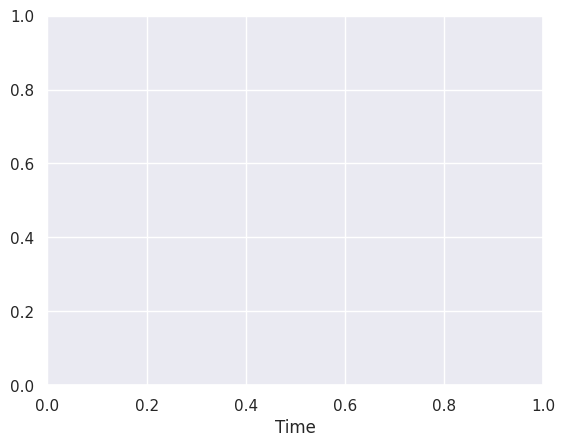

In [122]:
import matplotlib as mpl
mpl.use('Agg')
#mpl.rc('font', **font)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as md
import datetime
import numpy as np
from pytz import timezone
import pandas as pd
import arrow
import os
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

# Limits for graphs
VOLTAGE_LIM = 0.2
CURRENT_LIM = 40
POWER_LIM = 4




plt.close()
plt.xlabel("Time")
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(4,3), sharex=False)
fig.autofmt_xdate()

volt_color= 'tab:blue'

amp_color = 'tab:red'


volt_color1= 'tab:blue'
volt_style1 = 'dashed'
volt_color2= 'tab:green'
volt_style2 = 'dotted'
amp_color1 = 'tab:red'
amp_style1='dashed'
amp_color2 = 'tab:orange'
amp_style2='dashdot'

ax1.fmt_xdata = md.DateFormatter('%m-%d')
ax1.xaxis.set_major_formatter(md.DateFormatter('%m-%d'))
ax1.set_ylabel("Power")
ax1.grid(True)

ax2.fmt_xdata = md.DateFormatter('%m-%d')
ax2.xaxis.set_major_formatter(md.DateFormatter('%m-%d'))
ax2.set_ylabel("Power")
ax2.grid(True)

ax3.fmt_xdata = md.DateFormatter('%m-%d')
ax3.xaxis.set_major_formatter(md.DateFormatter('%m-%d'))
ax1.set_ylabel("Power")
ax2.set_ylabel("Voltage")
ax3.set_ylabel("Current")
ax3.grid(True)
#print('max power: ',max(max(1E6*df['power1']),max(1E6*df['power2'])))
#ax3.set_ylim(0, 4)
ax1.plot(mv1.index, 1E6*mv2["power_pred"], color=volt_color1, ls = volt_style1)
ax1.plot(mv1.index, 1E6*mv2['power'], color=volt_color2, ls = volt_style2)
ax1.legend(['predictions','actual'], loc='upper right', prop={'size': 6})

ax2.plot(mv1.index, 1E6*mv2["voltage_pred"], color=volt_color1, ls = volt_style1)
ax2.plot(mv1.index, 1E6*mv2['V1 [10nV]'], color=volt_color2, ls = volt_style2)
ax2.legend(['predictions','actual'], loc='upper right', prop={'size': 6})

ax3.plot(mv1.index, 1E6*mv2["current_pred"], color=volt_color1, ls = volt_style1)
ax3.plot(mv1.index, 1E6*mv2['I1L [10pA]'], color=volt_color2, ls = volt_style2)
ax3.legend(['predictions','actual'], loc='upper right', prop={'size': 6})


#Plot error
#ax3.plot(mv1['timestamp'], mv1['error']/mv1['power'], color=volt_color2, ls = volt_style2)
#ax3.legend(['error'], loc='upper right', prop={'size': 6})

ax3.tick_params(axis='x', labelsize=6, rotation=0)
#ax3.xaxis.set_major_locator(plt.MaxNLocator(6))
#ax3.set_xlim(mv.index[0], datetime.date(2020,5,19))
for label in ax3.get_xticklabels():
    label.set_horizontalalignment('center')

plt.tight_layout(pad=0.6, w_pad=0.5, h_pad=2.0)
plt.subplots_adjust(hspace=0.50)
plt.savefig('twobat.pdf')
plt.close()
#tot_energy = np.trapz(df['power1'])
#tot_energy = np.trapz(df['power2'])
#print(tot_energy)

In [ ]:
df

,sensorID,raw_VWC,temp,EC,I1L_valid,I2L_valid,I1H [nA],I1L [10pA],V1 [10nV],V2 [10nV],...,EC - 1h,temp - 1h,raw_VWC - 1h,V1 - 1h,I1L - 1h,I1H - 1h,power_pred,error,voltage_pred,current_pred
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-06-21 11:45:00-07:00,0.0,2483.198376,31.677780,230.057226,1.0,1.0,2.008008,155.585028,1034.402047,-6.506636e+06,...,229.132984,31.797855,2482.251785,1002.602407,156.543437,2.140071,1620.857788,10.293404,963.871277,164.997650
2021-06-21 12:00:00-07:00,0.0,2484.090080,31.543689,230.689802,1.0,1.0,2.037338,160.644143,994.960941,-6.140710e+06,...,230.057226,31.677780,2483.198376,1034.402047,155.585028,2.008008,1645.084839,50.202980,990.525391,162.947083
2021-06-21 12:15:00-07:00,0.0,2484.877240,31.376643,230.663287,1.0,1.0,2.117030,162.184592,958.719298,-5.836793e+06,...,230.689802,31.543689,2484.090080,994.960941,160.644143,2.037338,1621.695679,74.751843,956.213379,166.856766
2021-06-21 12:30:00-07:00,0.0,2485.646970,31.183712,230.685606,1.0,1.0,2.230271,174.872436,924.363395,-5.576357e+06,...,230.663287,31.376643,2484.877240,958.719298,162.184592,2.117030,1571.367065,37.754495,923.430176,167.201462
2021-06-21 12:45:00-07:00,0.0,2486.461667,30.975758,230.590909,1.0,1.0,2.373069,192.348231,891.331314,-5.345589e+06,...,230.685606,31.183712,2485.646970,924.363395,174.872436,2.230271,1617.625122,89.672428,895.077209,179.949890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-27 23:00:00-08:00,0.0,2695.823561,10.688636,217.571970,1.0,1.0,5.996213,175.097011,146.046570,-4.355352e+06,...,217.882576,10.663636,2696.044508,145.993928,172.602389,5.977703,280.450562,28.180893,141.691925,196.501175
2022-01-27 23:15:00-08:00,0.0,2695.746278,10.685448,217.643431,1.0,1.0,5.743371,188.632730,146.714588,-4.337490e+06,...,217.571970,10.688636,2695.823561,146.046570,175.097011,5.996213,283.834625,10.613392,141.794281,198.995056
2022-01-27 23:30:00-08:00,0.0,2695.788210,10.660448,218.113128,1.0,1.0,5.832302,203.473247,146.310942,-4.317909e+06,...,217.643431,10.685448,2695.746278,146.714588,188.632730,5.743371,301.325226,7.124274,142.273163,211.891785
